In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import sys
import pandas as pd
from tqdm import tqdm

In [5]:
dic = {}
dic['path'] = []
dic['covid_status'] = []
dic['cough_detected'] = []

path  = '/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID' #sf 48000
data_dir = path+'/public_dataset_wav'

csv_name = path + '/metadata_compiled.csv'
data = pd.read_csv(csv_name)

data = data.loc[data['cough_detected'] >= 0.9, ['uuid','cough_detected','status']]
data = data.dropna(how = "any")
data = data.reset_index(drop=True)
      
for i in tqdm(range(len(data))):
    dic['path'].append(data_dir + '/' + data['uuid'][i]+'.wav')
    dic['covid_status'].append(data['status'][i])
    dic['cough_detected'].append(data['cough_detected'][i])

100%|████████████████████████████████████| 6092/6092 [00:00<00:00, 82471.66it/s]


In [6]:
df = pd.DataFrame.from_dict(dic)
df

,path,covid_status,cough_detected
0,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy,0.9609
1,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy,0.9301
2,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy,0.9968
3,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy,0.9883
4,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,symptomatic,0.9456
...,...,...,...
6087,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy,0.9414
6088,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,COVID-19,0.9846
6089,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,symptomatic,0.9485
6090,/home/pmp/Workspace/Myoungjin/CoughData/Data/C...,healthy,0.9498


+ minimal cough length = 200ms
+ padding(기침이 감지된 전후의 추가된 샘플 신호) = 200ms
+ These thresholds are based on the physiology of cough sounds but can be adjusted to fit your applications.

In [7]:
#Use old segmentation
def segment_cough(x,fs, cough_padding=0.2,min_cough_len=0.2, th_l_multiplier = 0.1, th_h_multiplier = 2):
    """Preprocess the data by segmenting each file into individual coughs using a hysteresis comparator on the signal power
    
    Inputs:
    *x (np.array): cough signal
    *fs (float): sampling frequency in Hz
    *cough_padding (float): number of seconds added to the beginning and end of each detected cough to make sure coughs are not cut short
    *min_cough_length (float): length of the minimum possible segment that can be considered a cough
    *th_l_multiplier (float): multiplier of the RMS energy used as a lower threshold of the hysteresis comparator
    *th_h_multiplier (float): multiplier of the RMS energy used as a high threshold of the hysteresis comparator
    
    Outputs:
    *coughSegments (np.array of np.arrays): a list of cough signal arrays corresponding to each cough
    cough_mask (np.array): an array of booleans that are True at the indices where a cough is in progress"""
                
    cough_mask = np.array([False]*len(x))
    

    #Define hysteresis thresholds
    rms = np.sqrt(np.mean(np.square(x)))
    seg_th_l = th_l_multiplier * rms
    seg_th_h =  th_h_multiplier*rms

    #Segment coughs
    coughSegments = []
    padding = round(fs*cough_padding)
    min_cough_samples = round(fs*min_cough_len)
    cough_start = 0
    cough_end = 0
    cough_in_progress = False
    tolerance = round(0.01*fs)
    below_th_counter = 0
    
    for i, sample in enumerate(x**2):
        if cough_in_progress:
            if sample<seg_th_l:
                below_th_counter += 1
                if below_th_counter > tolerance:
                    cough_end = i+padding if (i+padding < len(x)) else len(x)-1
                    cough_in_progress = False
                    if (cough_end+1-cough_start-2*padding>min_cough_samples):
                        coughSegments.append(x[cough_start:cough_end+1])
                        cough_mask[cough_start:cough_end+1] = True
            elif i == (len(x)-1):
                cough_end=i
                cough_in_progress = False
                if (cough_end+1-cough_start-2*padding>min_cough_samples):
                    coughSegments.append(x[cough_start:cough_end+1])
            else:
                below_th_counter = 0
        else:
            if sample>seg_th_h:
                cough_start = i-padding if (i-padding >=0) else 0
                cough_in_progress = True
    
    return coughSegments, cough_mask

def compute_SNR(x, fs):
    """Compute the Signal-to-Noise ratio of the audio signal x (np.array) with sampling frequency fs (float)"""
    segments, cough_mask = segment_cough(x,fs)
    RMS_signal = 0 if len(x[cough_mask])==0 else np.sqrt(np.mean(np.square(x[cough_mask])))
    RMS_noise = np.sqrt(np.mean(np.square(x[~cough_mask])))
    SNR = 0 if (RMS_signal==0 or np.isnan(RMS_noise)) else 20*np.log10(RMS_signal/RMS_noise)
    return SNR


/home/pmp/Workspace/Myoungjin/CoughData/Data/COUGHVID/public_dataset_wav/00039425-7f3a-42aa-ac13-834aaa2b6b92.wav
234720
0.068224065
0.0
0.04041651
16


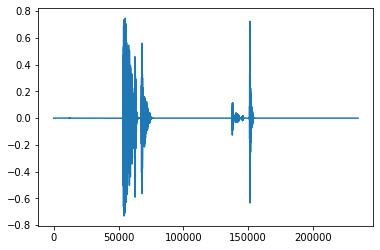

In [24]:
sr=24000
file = df['path'][0]
print(file)
y, sr = librosa.load(file, sr= sr, duration=None)
plt.plot(y)
print(len(y))
print(y[57360])
print(y[117360])
print(np.sqrt(np.mean(np.square(y))))
print(4**2)

Text(0.5, 1.0, 'Segmentation Output')

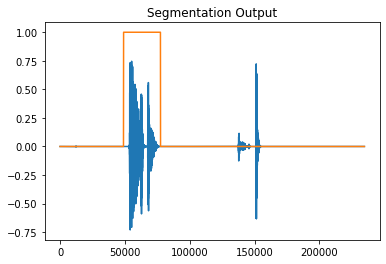

In [25]:
cough_segments, cough_mask = segment_cough(y,sr)
plt.plot(y)
plt.plot(cough_mask)
plt.title("Segmentation Output")

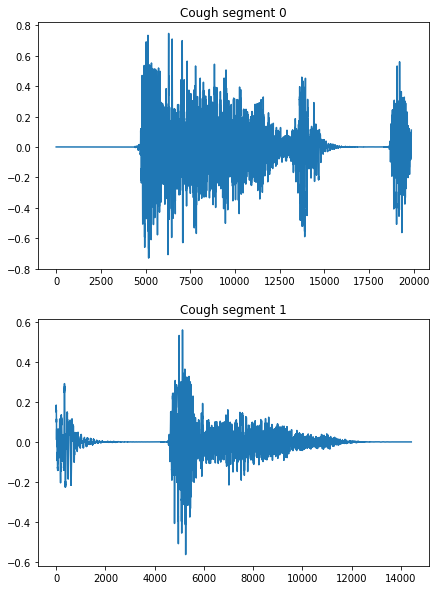

In [26]:
fig, axs = plt.subplots(len(cough_segments), 1, figsize=(7,10))
for i in range(0, len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment "+ str(i))

In [37]:
sr=24000
print(len(cough_segments[0]))
print(len(cough_segments[0])+len(cough_segments[1]))
mfccs = librosa.feature.mfcc(y=cough_segments[0],sr=sr, n_mfcc=13)
mfccsscaled = np.mean(mfccs.T,axis=0)
print(mfccs.shape)
print(mfccsscaled)
print("time :",len(cough_segments[0])/sr)
print("time :",len(cough_segments[1])/sr)

19859
34281
(13, 39)
[-291.9766     108.14449    -28.00458     52.36856    -35.021923
   36.991863   -15.934958    -7.5992312    2.8958397  -23.563265
   -9.249734   -24.906178     1.2357   ]
time : 0.8274583333333333
time : 0.6009166666666667


+ to remove extra signal before/after cough, modify cough_padding


Text(0.5, 1.0, 'Segmentation Output')

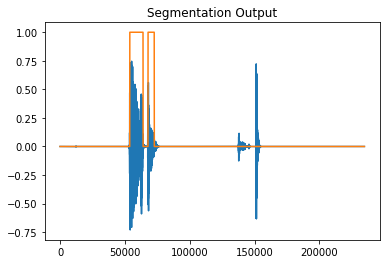

In [23]:
cough_segments, cough_mask = segment_cough(y,sr, cough_padding = 0)
plt.plot(y)
plt.plot(cough_mask)
plt.title("Segmentation Output")

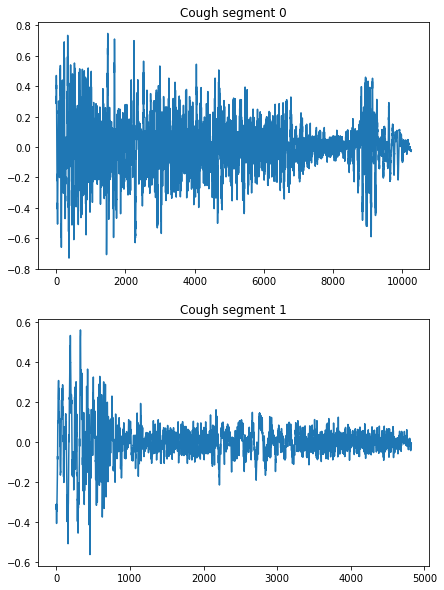

In [24]:
fig, axs = plt.subplots(len(cough_segments), 1, figsize=(7,10))
for i in range(0, len(cough_segments)):
    axs[i].plot(cough_segments[i])
    axs[i].set_title("Cough segment "+ str(i))

In [25]:
snr = compute_SNR(y,sr)
print("SNR = {0}".format(snr))

SNR = 16.317418813705444
